# Preprocessing

In [33]:
from read_corpus import *
import pandas as pd
import pickle

with open("corpus/cs_uters_with_cognatehood_sorted_streched.dat", "rb") as f:
    cs_uters = pickle.load(f)
    
with open("corpus/all_uter_with_cognatehood_sorted_streched.dat", "rb") as f:
    utterances = pickle.load(f)

In [34]:
print(len(cs_uters))
print(len(utterances))
# cs_uters = utterances

2799
42910


In [35]:
#BOW / tfidf
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=100)
uters_texts = [u.__str__() for u in cs_uters]
vectorizer.fit(uters_texts)
len(vectorizer.get_feature_names_out())

100

In [36]:
import plotly.express as px
import plotly.graph_objects as go
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

words_freq = get_top_n_words(uters_texts, 50)
words = [w[0] for w in words_freq]
freq = [w[1] for w in words_freq]

fig = go.Figure(data=[
    go.Bar(name='1', x=words, y=freq),
])
fig.update_layout(
    title=f"Words frequency",
    xaxis_title='word',
    yaxis_title="count",
)

fig.show()

In [37]:
def print_uter(uter):
    print(uter.filename)
    print(uter.uter_id)
    print(str(uter))
    tuples = []
    for t in uter.tokens:
        tuples.append((t.surface, t.lang, t.postag, t.bin_cognate, t.ner, t.cognatehood))
    print(tuples)
    
print_uter(cs_uters[0])

herring1.csv
67
and your grandmother was like oh todo se mira en las manos
[('and', 'eng', 'CONJ', 0, '', 0.4466), ('your', 'eng', 'DET', 0, '', 0.3318), ('grandmother', 'eng', 'NOUN', 0, '', 0.5106), ('was', 'eng', 'VERB', 0, '', 0.0), ('like', 'eng', 'ADV', 0, '', 0.4504), ('oh', 'shared_other', 'INTJ', 0, '', 0.0), ('todo', 'spa', 'PRON', 0, '', 0.2643), ('se', 'spa', 'PRON', 0, '', 0.0), ('mira', 'spa', 'VERB', 0, '', 0.3117), ('en', 'spa', 'ADP', 1, '', 0.0), ('las', 'spa', 'DET', 0, '', 0.0), ('manos', 'spa', 'NOUN', 0, '', 0.4779)]


In [38]:
pos_tags_map_name = {}
pos_tags_map_value = {}

pos_tags_map_value[0] = 'none'
pos_tags_map_name['none']=0

ner_map_name = {}
ner_map_value = {}

pos_tags_set = set()
ner_set = set()
for uter in cs_uters:
    for token in uter.tokens:
        pos_tags_set.add(token.postag)
        ner_set.add(token.ner)
        
for i, pt in enumerate(pos_tags_set, start=1):
    pos_tags_map_value[i] = pt
    pos_tags_map_name[pt] = i

for i, n in enumerate(ner_set, start=0):
    ner_map_name[n] = i
    ner_map_value[i] = n

print(pos_tags_map_name)
print(pos_tags_map_value)
print()
print(ner_map_name)
print(ner_map_value)

{'none': 0, 'ADP': 1, 'ADV': 2, 'NUM': 3, 'PROPN': 4, 'VERB': 5, 'INTJ': 6, 'PART': 7, 'NOUN': 8, 'AUX': 9, 'CONJ': 10, 'ADJ': 11, 'SCONJ': 12, 'DET': 13, 'PRON': 14, 'X': 15}
{0: 'none', 1: 'ADP', 2: 'ADV', 3: 'NUM', 4: 'PROPN', 5: 'VERB', 6: 'INTJ', 7: 'PART', 8: 'NOUN', 9: 'AUX', 10: 'CONJ', 11: 'ADJ', 12: 'SCONJ', 13: 'DET', 14: 'PRON', 15: 'X'}

{'': 0}
{0: ''}


In [51]:
from tqdm import tqdm

k=5   # context / window size
min=2 # keep the starting vectors of each uter

def vectors_in_window(arr):
    result = [arr[0:min+i] for i in range(k-min)]
    result.extend([arr[i:i+k] for i in range(len(arr)-k+1)])
    return result

def is_cs(lng_vec):
    curr = lng_vec[-1]
    prev = lng_vec[-2]
    
    if curr == 'eng' and prev == 'spa':
        return 1
    if curr == 'spa' and prev == 'eng':
        return 1
    
    # check shared other
    if prev == "shared_other" and len(lng_vec) > 2:
        prev_prev = lng_vec[-3]
        return 1 if prev_prev != prev != curr else 0
    
    return 0
    

def vectorize(uter, with_words=True, debug=False):
    raw = vectors_in_window(uter.tokens)
    df = pd.DataFrame()
    for vec_idx, v in enumerate(raw):
        vec_key = f'{uter.filename}_{uter.uter_id}_{vec_idx}'

        pos_tag_vec = []
        text_vec = []
        len_vec = []
        ipa_len_vec = []
        lng_vec = []
        cognatehood_vec = []
#         bin_cognate_vec = []
#         ner_vec = []
        
        for t in v:
            pos_tag_vec.append(t.postag)
            text_vec.append(t.surface)
            lng_vec.append(t.lang)
            len_vec.append(t.len)
            ipa_len_vec.append(t.ipa_len)
            cognatehood_vec.append(t.cognatehood)
#             bin_cognate_vec.append(t.bin_cognate)
#             ner_vec.append(t.ner)
            if debug: print((t.surface, t.lang, t.postag, t.cognatehood))
        
        sub_uter = ' '.join(text_vec)
        
        if len(lng_vec) < min:
            continue

        label = is_cs(lng_vec)
        pos_tag_vec = [pos_tags_map_name[p] for p in pos_tag_vec]
#         ner_vec = [ner_map_name[n] for n in ner_vec]
        
        # fix short vectors to K
        for _ in range(k-len(v)):
            pos_tag_vec.insert(0, pos_tags_map_name['none'])
            len_vec.insert(0, 0)
            ipa_len_vec.insert(0, 0)
            cognatehood_vec.insert(0,0)
#             bin_cognate_vec.insert(0, 0)
#             ner_vec.insert(0, ner_map_name['other'])
            
        if with_words:
            text_vec = vectorizer.transform([sub_uter]).toarray()[0]
            text_words = vectorizer.get_feature_names_out()
            
        # convert to pandas
        data = {f'len_{i}':[l] for i, l in enumerate(len_vec)}
        data.update({f'ipa_len_{i}':[l] for i, l in enumerate(ipa_len_vec)})
#         data.update({f'bin_cognate_{i}':[l] for i, l in enumerate(bin_cognate_vec)})
        data.update({f'cognatehood_{i}':[l] for i, l in enumerate(cognatehood_vec)})

        data.update({f'postag_{i}':[p] for i, p in enumerate(pos_tag_vec)})
#         data.update({f'ner_{i}':[p] for i, p in enumerate(ner_vec)})
        if with_words:
            data.update({f'w_{text_words[i]}':[p] for i, p in enumerate(text_vec)})
        data.update({'label': label, 'sub_uter':sub_uter ,'full_uter': str(uter), 'key': vec_key})

        df = pd.concat([df, pd.DataFrame.from_dict(data)])
        
        if debug:
            print(sub_uter)
            print('lng:', lng_vec)
            print('len vec:', len_vec)
            print('postag vec:', pos_tag_vec)
#             print('binary cognate vec:', bin_cognate_vec)
#             print('ner vec:', ner_vec)
            print('cognatehood vec:', cognatehood_vec)

            print('label:', label)
            print()
    return df



# vectorize(cs_uters[0], with_words=True, debug=True)
df = pd.DataFrame()
for uter in tqdm(cs_uters):
    df = pd.concat([df, vectorize(uter, with_words=True)])
df.head()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2799/2799 [01:09<00:00, 40.43it/s]


,len_0,len_1,len_2,len_3,len_4,ipa_len_0,ipa_len_1,ipa_len_2,ipa_len_3,ipa_len_4,...,w_when,w_with,w_ya,w_yeah,w_yo,w_you,label,sub_uter,full_uter,key
0,0,0,0,3,4,0,0,0,3,3,...,0,0,0,0,0,0,0,and your,and your grandmother was like oh todo se mira ...,herring1.csv_67_0
0,0,0,3,4,11,0,0,3,3,10,...,0,0,0,0,0,0,0,and your grandmother,and your grandmother was like oh todo se mira ...,herring1.csv_67_1
0,0,3,4,11,3,0,3,3,10,3,...,0,0,0,0,0,0,0,and your grandmother was,and your grandmother was like oh todo se mira ...,herring1.csv_67_2
0,3,4,11,3,4,3,3,10,3,4,...,0,0,0,0,0,0,0,and your grandmother was like,and your grandmother was like oh todo se mira ...,herring1.csv_67_3
0,4,11,3,4,2,3,10,3,4,2,...,0,0,0,0,0,0,0,your grandmother was like oh,and your grandmother was like oh todo se mira ...,herring1.csv_67_4


In [11]:
# vectorize(cs_uters[15], False, True)
# print(cs_uters[5])

# CLS

In [15]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, accuracy_score
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import seaborn as sns
from sklearn import tree

In [54]:
# balance the data:
balance = True
print('all:', len(df))

if balance:
    pos_df = (df[df['label'] == 1])
    neg_df = (df[df['label'] == 0])
    print('label1:', len(pos_df))
    print('label0:', len(neg_df))
    print('down sampling:')


    neg_df = resample(neg_df,
                      replace=True,     # sample with replacement
                      n_samples=len(pos_df),    # to match majority class
                      random_state=42) # reproducible results

    print('label0:', len(neg_df))
    bdf = pd.concat([pos_df, neg_df])
    print('all:', len(bdf))
else:
    bdf = df.copy()
    

# remove unused cols
bdf_copy = bdf.copy()
labels = bdf['label']
bdf.drop(['label', 'sub_uter', 'full_uter', 'key'], axis=1, inplace=True)
# bdf.to_csv('full_data_k_5.csv')
print(labels.value_counts())

neg = labels.value_counts().tolist()[0]
pos = labels.value_counts().tolist()[1]
majority_cls_acc = neg/(pos+neg)
print('majority_cls_acc: ', majority_cls_acc)


def remove_feature(feature_prefix):
    features = [f'{feature_prefix}_{i}' for i in range(k)]
    bdf.drop(features, axis=1, inplace=True)

# remove_feature('len')
# remove_feature('ipa_len')
# remove_feature('postag')
# remove_feature('bin_cognate')
# remove_feature('ner')
bdf

all: 28059
label1: 4159
label0: 23900
down sampling:
label0: 4159
all: 8318
1    4159
0    4159
Name: label, dtype: int64
majority_cls_acc:  0.5


,len_0,len_1,len_2,len_3,len_4,ipa_len_0,ipa_len_1,ipa_len_2,ipa_len_3,ipa_len_4,...,w_voy,w_was,w_we,w_what,w_when,w_with,w_ya,w_yeah,w_yo,w_you
0,11,3,4,2,4,10,3,4,2,4,...,0,1,0,0,0,0,0,0,0,0
0,0,0,0,2,2,0,0,0,3,2,...,0,0,0,0,0,0,0,0,0,0
0,4,5,4,4,3,6,5,6,2,3,...,0,0,0,0,0,0,0,0,0,0
0,0,0,4,2,3,0,0,4,2,2,...,0,0,0,0,0,0,0,0,0,1
0,0,0,0,6,2,0,0,0,5,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2,5,4,3,5,3,5,4,3,5,...,0,0,0,0,0,0,0,0,0,0
0,0,0,3,5,3,0,0,3,5,3,...,0,0,0,0,0,0,0,0,0,0
0,3,6,2,6,2,2,6,2,5,2,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,3,1,0,0,0,3,1,...,0,0,0,0,0,0,0,0,0,0


In [21]:
md = 17

In [55]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
import numpy as np
from sklearn.preprocessing import StandardScaler


# scaler = StandardScaler()
# bdf_tr = scaler.fit_transform(bdf)
# clf = LogisticRegression(random_state=0, max_iter=10000)

clf = RandomForestClassifier(criterion='entropy', max_depth=None)
cv_scores = cross_val_score(clf, bdf, labels, cv=10)
print(cv_scores)
print(np.mean(cv_scores))

[0.74399038 0.76201923 0.72235577 0.76442308 0.73677885 0.74759615
 0.75841346 0.73076923 0.76534296 0.7244284 ]
0.7456117513653615


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:46<00:00, 18.51s/it]


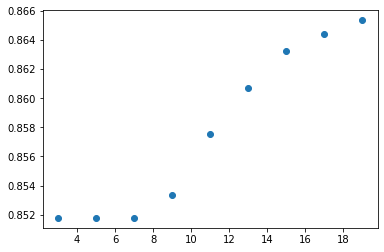

In [26]:
# small max at 17

range_ = [3,5,7,9,11,13,15,17,19]
# range_ = [3,7,11,15,19]
scores = []
for md in tqdm(range_):
    clf = RandomForestClassifier(criterion='entropy', max_depth=md)
    cv_scores = cross_val_score(clf, bdf, labels, cv=10)
    scores.append(np.mean(cv_scores))
plt.scatter(range_, scores)

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      4780
           1       0.75      0.20      0.31       832

    accuracy                           0.87      5612
   macro avg       0.81      0.59      0.62      5612
weighted avg       0.86      0.87      0.84      5612



<Figure size 432x288 with 0 Axes>

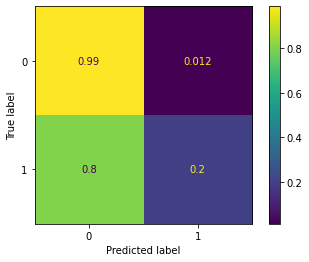

<Figure size 432x288 with 0 Axes>

In [47]:
X_train, X_test, y_train, y_test = train_test_split(bdf, labels, random_state=0, test_size=0.2, stratify=labels)

xtrain = X_train
xtest = X_test

clf = RandomForestClassifier(criterion='entropy', max_depth=None)
clf.fit(xtrain, y_train)
feature_imp_ = pd.Series(clf.feature_importances_,index=bdf.columns.tolist()).sort_values(ascending=False)

y_pred = clf.predict(xtest)
print(classification_report(y_test, y_pred, labels=clf.classes_))


cm = confusion_matrix(y_test, y_pred, labels=clf.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.figure()
# print('max_depth:', md)


In [48]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif, chi2
#Suppose, we select 5 features with top 5 Fisher scores
selector = SelectKBest(chi2, k = 20)
#New dataframe with the selected features for later use in the classifier. fit() method works too, if you want only the feature names and their corresponding scores
X_new = selector.fit_transform(bdf, labels)
names = bdf.columns.values[selector.get_support()]
scores = selector.scores_[selector.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)

       Feat_names    F_Scores
16       postag_1  694.525437
15       postag_0  591.974603
8       ipa_len_3  468.024701
3           len_3  401.279344
0           len_0  266.750087
19       postag_4  252.556911
5       ipa_len_0  238.364729
4           len_4  224.422034
9       ipa_len_4  213.286042
17       postag_2  211.981396
1           len_1  153.488835
6       ipa_len_1  135.841769
2           len_2   90.047113
18       postag_3   67.788057
7       ipa_len_2   64.814413
13  cognatehood_3   50.826904
14  cognatehood_4   25.005413
10  cognatehood_0   24.576462
11  cognatehood_1   14.271559
12  cognatehood_2    3.757424


# Data

In [49]:
def plot_importance(feature_imp_):
    feature_imp_ = feature_imp_[0:20]
    sns.barplot(x=feature_imp_, y=feature_imp_.index)
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Feature Importance Score")
    plt.show()
    
def pos_tag_map_for_plot(df_, feature):
    tags = list(df_[feature])
    tags_names = [pos_tags_map_value[tag] for tag in tags]
    df_[feature] = tags_names
    
def ner_map_for_plot(df_, feature):
    tags = list(df_[feature])
    tags_names = [ner_map_value[tag] for tag in tags]
    df_[feature] = tags_names
    

def hist_feature(feature):
    df_ = bdf_copy.copy()
    df_["label"] = df_["label"].astype(str)
    
    if feature.startswith('postag'):
        pos_tag_map_for_plot(df_, feature)
        
    if feature.startswith('ner'):
        ner_map_for_plot(df_, feature)

    pos_df = (df_[df_['label'] == '1'])
    neg_df = (df_[df_['label'] == '0'])
    
    pos_values = pos_df[feature].value_counts()
    neg_values = neg_df[feature].value_counts()

    fig = go.Figure(data=[
        go.Bar(name='1', x=list(pos_values.keys()), y=pos_values.tolist()),
        go.Bar(name='0', x=list(neg_values.keys()), y=neg_values.tolist()),
    ])

    fig.update_layout(
        title=f"{feature} ordered histogram",
        xaxis_title=feature,
        yaxis_title="count",
        legend_title="CS label",
    )
    fig.update_xaxes(categoryorder='total ascending')
    fig.show()

    
def cont_hist_feature(feature):
    df_ = bdf_copy.copy()
    df_["label"] = df_["label"].astype(str)


    pos_df = (df_[df_['label'] == '1'])
    neg_df = (df_[df_['label'] == '0'])

    pos_values = pos_df[feature].value_counts()
    neg_values = neg_df[feature].value_counts()

    fig = go.Figure(data=[
        go.Scatter(name='1', x=list(pos_values.keys()), y=pos_values.tolist(), mode="markers", opacity=1),
        go.Scatter(name='0', x=list(neg_values.keys()), y=neg_values.tolist(), mode="markers", opacity=0.5),
    ])
    
    pos_wei_avg = sum(pos_values.keys() * pos_values.tolist()) / sum(pos_values.tolist())
    neg_wei_avg = sum(neg_values.keys() * neg_values.tolist()) / sum(neg_values.tolist())
    
    print(f"CS 1 - weighted average: {pos_wei_avg}")
    print(f"CS 0 - weighted average: {neg_wei_avg}")


    fig.update_layout(
        title=f"{feature}",
        xaxis_title=f"{feature} score",
        yaxis_title="count",
        legend_title="CS label",
    )
    fig.show()

    
def plot_2_features_heatmap(x,y,feature0, feature1, title, z):
    fig = px.imshow(z, labels=dict(x=feature0, y=feature1, color="count"),x=x,y=y)
    fig.update_layout(title=title)
    fig.show()
    
    
def plot_pos_tag_heatmap(feature0, feature1):
    df_ = bdf_copy.copy()
    df_["label"] = df_["label"].astype(str)

    table_size = len(pos_tags_map_value)

    pos_counts = np.zeros([table_size,table_size])
    neg_counts = np.zeros([table_size,table_size])

    for _, row in df_.iterrows():
        if row['label'] == '1':
            pos_counts[row[feature1]][row[feature0]] += 1
        else:
            neg_counts[row[feature1]][row[feature0]] += 1


    x = list(pos_tags_map_value.values())
    y = list(pos_tags_map_value.values())  

    plot_2_features_heatmap(x,y,feature0,feature1,
                            title=f"Counts of samples with label 0: {feature0} vs {feature1}",
                            z=neg_counts)

    plot_2_features_heatmap(x,y,feature0,feature1,
                            title=f"Counts of samples with label 1: {feature0} vs {feature1}",
                            z=pos_counts)

    plot_2_features_heatmap(x,y,feature0,feature1,
                            title=f"label 1 > label 0: {feature0} vs {feature1}",
                            z=(pos_counts>neg_counts).astype(int))
    
    return pos_counts, neg_counts

def plot_ner_heatmap(feature0, feature1):
    df_ = bdf_copy.copy()
    df_["label"] = df_["label"].astype(str)

    table_size = len(ner_map_value)

    pos_counts = np.zeros([table_size,table_size])
    neg_counts = np.zeros([table_size,table_size])

    for _, row in df_.iterrows():
        if row['label'] == '1':
            pos_counts[row[feature1]][row[feature0]] += 1
        else:
            neg_counts[row[feature1]][row[feature0]] += 1


    x = list(ner_map_value.values())
    y = list(ner_map_value.values())  

    plot_2_features_heatmap(x,y,feature0,feature1,
                            title=f"Counts of samples with label 0: {feature0} vs {feature1}",
                            z=neg_counts)

    plot_2_features_heatmap(x,y,feature0,feature1,
                            title=f"Counts of samples with label 1: {feature0} vs {feature1}",
                            z=pos_counts)

    plot_2_features_heatmap(x,y,feature0,feature1,
                            title=f"label 1 > label 0: {feature0} vs {feature1}",
                            z=(pos_counts>neg_counts).astype(int))
    
    return pos_counts, neg_counts


def get_top_n_indices(vec, N):
    # Convert it into a 1D array
    vec_1d = vec.flatten()
    idx_1d = vec_1d.argsort()[-N:]
    x_idx, y_idx = np.unravel_index(idx_1d, vec.shape)
    return x_idx, y_idx

    
def plot_sorted_2_featues(vec, group, N, map_, feature_title):
    a_idx, b_idx = get_top_n_indices(vec, N)
    feature_names = []
    values = []
    for a, b, in zip(a_idx, b_idx):
        feature_name = f'{map_[b]}_{map_[a]}'
        feature_names.append(feature_name)
        values.append(vec[a][b])

    fig = go.Figure(data=[
        go.Bar(name='1', x=feature_names, y=values),
    ])

    fig.update_layout(
        title=f"{group}: 2 features - ordered histogram",
        xaxis_title=feature_title,
        yaxis_title="count",
    )

    fig.show()

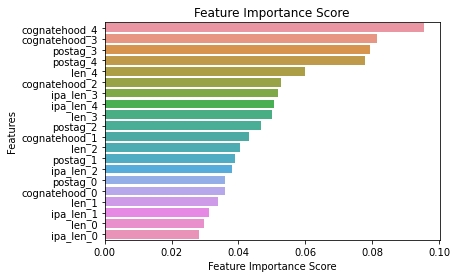

CS 1 - weighted average: 0.2928734070690069
CS 0 - weighted average: 0.23387346443514695


CS 1 - weighted average: 0.29796989660976253
CS 0 - weighted average: 0.255016405857741


CS 1 - weighted average: 0.13576835777831217
CS 0 - weighted average: 0.16955520083681994


CS 1 - weighted average: 0.16506633806203425
CS 0 - weighted average: 0.1926265020920503


CS 1 - weighted average: 0.20135039672998334
CS 0 - weighted average: 0.21642292887029357


In [50]:
plot_importance(feature_imp_)
hist_feature('postag_3')
hist_feature('postag_4')
# hist_feature('postag_1')
cont_hist_feature('cognatehood_3')
cont_hist_feature('cognatehood_4')
cont_hist_feature('cognatehood_0')
cont_hist_feature('cognatehood_1')
cont_hist_feature('cognatehood_2')

pos_counts, neg_counts = plot_pos_tag_heatmap('postag_3', 'postag_4')
plot_sorted_2_featues(pos_counts, 'label 1', 10, pos_tags_map_value, 'postag 3-4')
plot_sorted_2_featues(neg_counts, 'label 0', 10, pos_tags_map_value, 'postag 3-4')

In [17]:
# hist_feature('ner_3')
# hist_feature('ner_4')
# pos_ner_counts, neg_ner_counts = plot_ner_heatmap('ner_3', 'ner_4')
# plot_sorted_2_featues(pos_ner_counts, 'label 1', 10, ner_map_value, 'ner 3-4')
# plot_sorted_2_featues(neg_ner_counts, 'label 0', 10, ner_map_value, 'ner 3-4')

# Explore

In [53]:
# exploring the data - pos tag 3 vs 4, in CS samples
most_pos = pos_counts>neg_counts
f1_vec ,f0_vec = np.where(most_pos == True)
for f1, f0 in zip(f1_vec, f0_vec):
    f1_name = pos_tags_map_value[f1]
    f0_name = pos_tags_map_value[f0]
    print('pos4:', f1_name, 'pos3:', f0_name)
    print('label1 count:', pos_counts[f1, f0])
    print('label0 count:', neg_counts[f1, f0])

pos4: none pos3: none
label1 count: 1.0
label0 count: 0.0
pos4: NUM pos3: ADV
label1 count: 3.0
label0 count: 1.0
pos4: NUM pos3: INTJ
label1 count: 2.0
label0 count: 0.0
pos4: NUM pos3: CONJ
label1 count: 4.0
label0 count: 0.0
pos4: X pos3: NUM
label1 count: 60.0
label0 count: 46.0
pos4: X pos3: SCONJ
label1 count: 34.0
label0 count: 17.0
pos4: X pos3: ADV
label1 count: 65.0
label0 count: 44.0
pos4: X pos3: INTJ
label1 count: 48.0
label0 count: 31.0
pos4: X pos3: ADJ
label1 count: 1.0
label0 count: 0.0
pos4: X pos3: CONJ
label1 count: 151.0
label0 count: 28.0
pos4: SCONJ pos3: NUM
label1 count: 2.0
label0 count: 0.0
pos4: SCONJ pos3: X
label1 count: 36.0
label0 count: 23.0
pos4: SCONJ pos3: INTJ
label1 count: 1.0
label0 count: 0.0
pos4: ADV pos3: X
label1 count: 58.0
label0 count: 53.0
pos4: ADV pos3: CONJ
label1 count: 1.0
label0 count: 0.0
pos4: INTJ pos3: SCONJ
label1 count: 2.0
label0 count: 1.0
pos4: INTJ pos3: INTJ
label1 count: 15.0
label0 count: 3.0
pos4: INTJ pos3: PRON
label

In [54]:
# explore contenct of uterances with a given pos tag 3-4
edf = df.copy()
pos_df = (edf[edf['label'] == 1])
neg_df = (edf[edf['label'] == 0])
pos3_filter = edf[edf['postag_3'] == 11]
cross = pos3_filter[pos3_filter['postag_4'] == 3]
cross
# cross.to_csv('pos3-intj_pos4-adj.csv')

,len_0,len_1,len_2,len_3,len_4,ipa_len_0,ipa_len_1,ipa_len_2,ipa_len_3,ipa_len_4,...,postag_4,ner_0,ner_1,ner_2,ner_3,ner_4,label,sub_uter,full_uter,key
0,4,2,1,3,4,3,2,1,3,4,...,3,2,2,2,2,2,0,mean it 's not like,i mean it 's not like you know uno dos tres cu...,herring9.csv_755_4
0,7,3,3,2,3,6,3,3,2,2,...,3,2,2,9,2,2,1,waiting for her to que,so they 're waiting for her to que se vaya de ...,zeledon14.csv_749_6
0,2,5,7,1,3,2,4,8,1,2,...,3,2,2,2,2,2,1,se llama jackson 's que,o un lugar que se llama jackson 's que venden ...,zeledon8.csv_188_7
0,4,3,3,2,3,3,2,2,2,2,...,3,2,9,2,2,2,1,that you are n't que,pena es y ahi despues te pongo otros cien en e...,zeledon8.csv_796_17
0,3,2,1,3,4,3,2,1,3,3,...,3,2,2,2,2,2,0,but it 's not that,sabes no es but it 's not that great either,zeledon8.csv_1221_6
